# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

**Гипотеза:**

**Нулевая:** После внедрения рекомендаций доля успешных сессий не изменилась (H0 : µA = µB) 

**Альтернативная:** После внедрения рекомендаций доля успешных сессий изменилась (H1 : µA ≠ µB) 

**Основная метрика для проверки равенства выборок**: среднее количество страниц просмотренных пользователями в рамках сессии.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd

In [2]:
sessions_history = pd.read_csv('sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [3]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


В данных нет пропусков, в дальнейшем шаг их обработки можно пропустить.  
Некоторые поля содержат информацию, для которой необходимо сменить тип данных, например: данные о дате и времени (`session_date`, `session_start_ts`, `install_date`) и др.

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
sessions_history.groupby('user_id')['session_id'].count().sort_values(ascending = False)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

Результат демонстрирует, что у всех пользователей количество сессий варируется  от 1 до 10

In [5]:
sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


В разрезе одного пользователя с большим количеством сессий заметно как именно формируютсяя данные в рамках таблицы. Неизменныными в рамках всех записей остается id пользователя, дата установки, регион и тип устройства. Также неизменно и поле регистрации, вероятнее всего при регистрации в поле буде указана единица. Поле `session_number` автоматически заполняется упорядочено в зависимости от ее очередности для данного пользователя отсортированной по дате. Дата сессии также заполняется автоматически от поле дата и время старта сессии.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [6]:
#Преобразем поле с датами и временем, перед началом работы в этом разделе
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])

In [7]:
sessions_history_agg = sessions_history.groupby('session_date').agg({'user_id':'count', 'registration_flag':'sum'}).reset_index()
display(sessions_history_agg)

,session_date,user_id,registration_flag
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


In [8]:
#Подключим библиотеку для визуализации графиков
import matplotlib.pyplot as plt

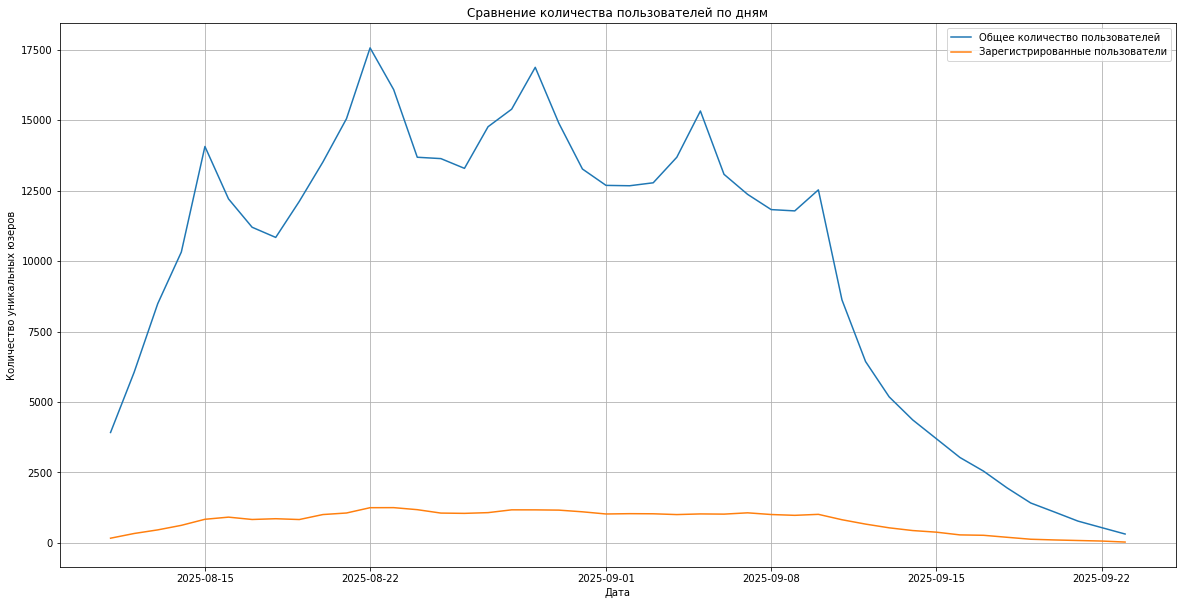

In [9]:
x = sessions_history_agg.session_date.unique()
y_a = sessions_history_agg.user_id
y_b = sessions_history_agg.registration_flag

plt.figure(figsize=(20, 10))
plt.plot(x, y_a, label ='Общее количество пользователей')
plt.plot(x, y_b, label ='Зарегистрированные пользователи')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных юзеров")
plt.legend()
plt.grid()
plt.title('Сравнение количества пользователей по дням')
plt.show()

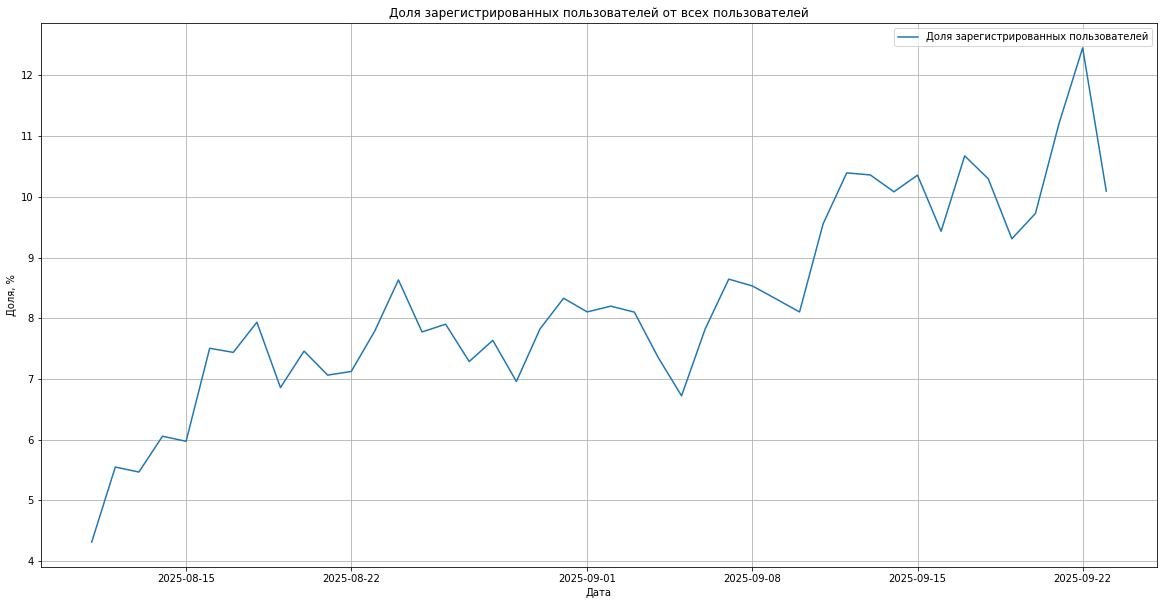

In [10]:
x = sessions_history_agg.session_date.unique()
y = sessions_history_agg.registration_flag / sessions_history_agg.user_id * 100 

plt.figure(figsize=(20, 10))
plt.plot(x, y, label ='Доля зарегистрированных пользователей')


plt.xlabel("Дата")
plt.ylabel("Доля, %")
plt.legend()
plt.grid()
plt.title('Доля зарегистрированных пользователей от всех пользователей')
plt.show()

На графиках видно, что количество зарегистрированных пользователей составляет малую часть от общего количества пользователей приложения. Однако, **доля зарегистрированных пользователей имеет тенденцию на увеличение**. В целом в данных заметно наличие пиковых дней, когда количество пользователей максмально в период, возможно в данных присуствует сезонность (например: на выходных просмотров может быть больше). Также с 10 сентября количество пользоваетелей ежедневно уменьшалось, возможно с приложением что-то произошло (например: произошло обновление, из-за которого стало неудобно им пользоваеться).

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [11]:
# Для начала рассмотрим как респределились данные по количеству просмотренных страниц в рамках одной сессии
sessions_history_pc = sessions_history['page_counter'].value_counts().reset_index().sort_values(by = 'index')
display(sessions_history_pc)

,index,page_counter
3,1,29160
2,2,105536
0,3,166690
1,4,105569
4,5,26288
5,6,2589
6,7,92


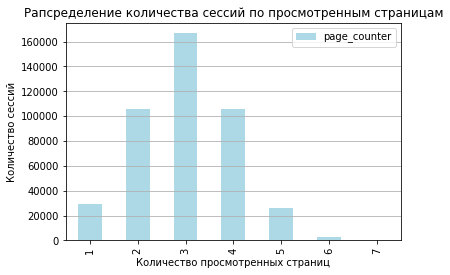

In [12]:
# Построим столбчатую диаграмму распределения количества просмотренных страниц в рамках одной сесссии
sessions_history_pc.plot(kind = 'bar', x = 'index', y = 'page_counter',color = 'lightblue')
plt.grid (axis = 'y')
plt.title('Рапсределение количества сессий по просмотренным страницам')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.show()

Распределение по количеству просмотренных страниц похоже на нормальное, в среднем пользователи просматривают около трех страниц, при этом разброс от 1 до 7.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [13]:
# Создадим новый столбец `good_session` в столбец `sessions_history`
def good_sessions (row):
    if row['page_counter'] >= 4:
        return 1
    else:
        return 0
    
sessions_history['good_session'] = sessions_history.apply(good_sessions, axis = 1)

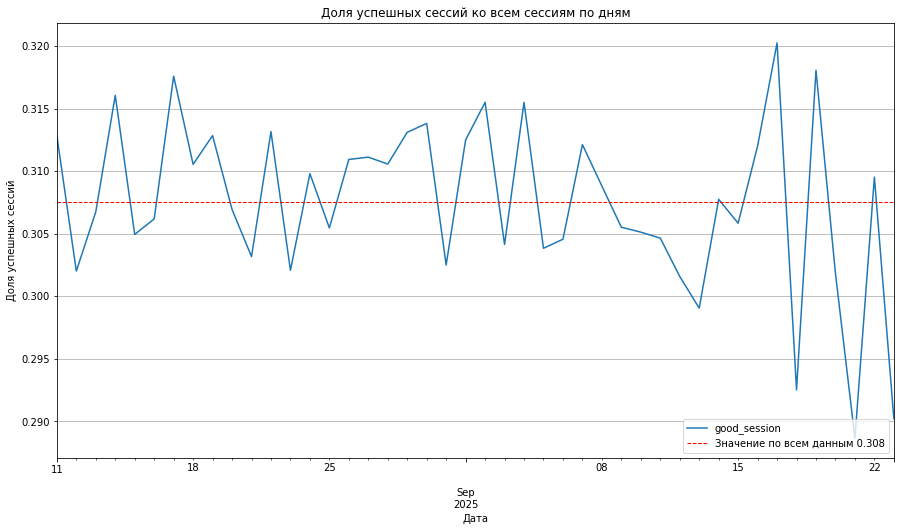

In [14]:
# Построим график со средним значением доли успешных сессий
sessions_history.groupby('session_date')['good_session'].mean().plot(kind = 'line', figsize = (15,8),
                                                                    xlabel = 'Дата', ylabel = 'Доля успешных сессий',
                                                                    title = 'Доля успешных сессий ко всем сессиям по дням')
mean_value = sessions_history.groupby('session_date')['good_session'].mean().mean()
plt.axhline(mean_value, color = 'red', linestyle = '--',
               linewidth = 1, label = f'Значение по всем данным {round(mean_value,3)}')
plt.grid(axis = 'y')
plt.legend(loc='lower right')
plt.show()

Из графика видно, что данные о доли успешных просмотров в разрезе каждого дня нестабильны и имеют разброс, однако при этом в большинстве случаев концентрируется у среднего значения 0.308 (приблизительно 31%) успешных просмотров от всех просмотров за указанный период.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [15]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - 0.2  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [16]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].count().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [17]:
# Создадим новый датасет для работы
sessions_test_part = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


В таблице появился новый столбец `test_group`, в котором хранятся значения **A** или **B**.


In [18]:
sessions_test_part[sessions_test_part['session_date'] == '2025-10-14'].groupby('test_group')['user_id'].nunique()

test_group
A    1477
B    1466
Name: user_id, dtype: int64

За 14 октября 2025 года количество уникальных пользователей, вошешдших на платформу составило 2943 человек, из них: 1466 - экспериментальная группа, 1477 - контрольная группа.

In [19]:
abs(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() - sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()) * 100 / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()

0.7447528774542993

Процентная разница между группами составила 8.39%

In [20]:
100 * sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()/sessions_test_part['user_id'].nunique(), 100 * sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()/sessions_test_part['user_id'].nunique()

(50.18688413183826, 49.81311586816174)

При этом процентное соотношение групп за один день составило 49,81% - контрольная группа, и 50,19% - тестовая группа.

<AxesSubplot:ylabel='Количество сессий'>

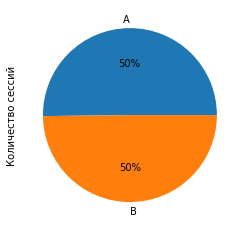

In [21]:
sessions_test_part.groupby('test_group')['user_id'].nunique().plot(kind = 'pie', ylabel = 'Количество сессий', autopct='%1.0f%%')

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [22]:
group_a = sessions_test_part[sessions_test_part['test_group']=='A']['user_id']
group_b = sessions_test_part[sessions_test_part['test_group']=='B']['user_id']
intersection = list(set(group_a)&set(group_b))
display(intersection)

[]

В данных не обнаружено пересечения пользователей.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [23]:
# Для начала выведем общий список с информацией о количестве пользователей 
# по группам теста и типу устройства
sessions_test_part.groupby(['test_group','device'])['user_id'].count()

test_group  device 
A           Android    656
            Mac        160
            PC         379
            iPhone     307
B           Android    723
            Mac        197
            PC         402
            iPhone     306
Name: user_id, dtype: int64

Учитывая что данные в файле представлены за один день и пользователь может войти один раз в день (по условию), то можно взглянуть на распределение втаком виде. Группы пользователей в рамках тестовых групп варируется по следующим типам устройств: Android - 723 и 656, Mac - 197 и 160, PC - 402 и 379, iPhone - 306 и 307 для групп B и A соотвественно.

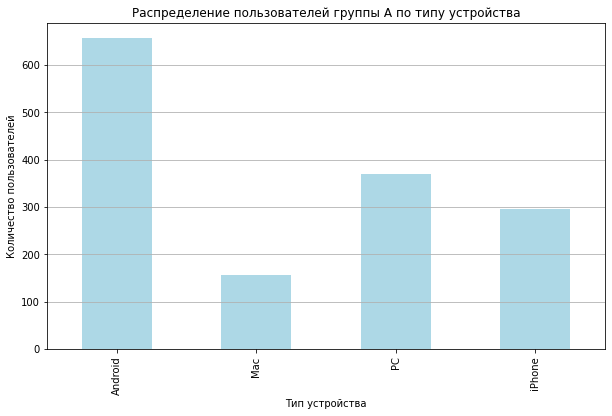

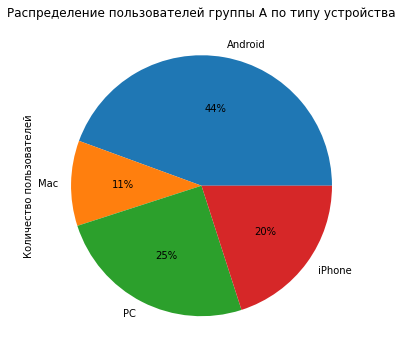

In [24]:
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().plot(kind ='bar',
                                                                                           color = 'lightblue',
                                                                                           figsize = (10,6),
                                                                                           xlabel = 'Тип устройства',
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы А по типу устройства')
plt.grid(axis = 'y')
plt.show()
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().plot(kind ='pie',
                                                                                           figsize = (10,6),
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы А по типу устройства',
                                                                                         autopct='%1.0f%%')
plt.show()

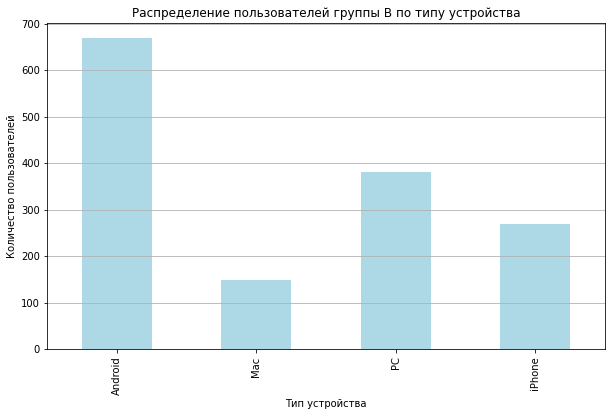

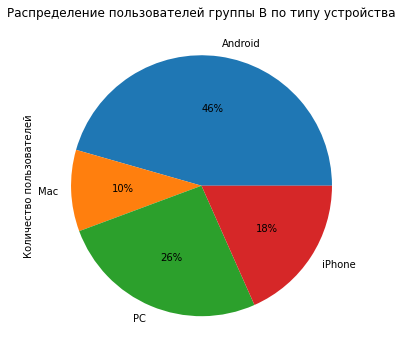

In [25]:
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().plot(kind ='bar',
                                                                                           color = 'lightblue',
                                                                                           figsize = (10,6),
                                                                                           xlabel = 'Тип устройства',
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы B по типу устройства')
plt.grid(axis = 'y')
plt.show()
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().plot(kind ='pie',
                                                                                           figsize = (10,6),
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы B по типу устройства',
                                                                                         autopct='%1.0f%%')
plt.show()

Данные распределились почти одинаково, по данным в группе В пользователей больше чем в А, однако в количестве пользователей с iPhone есть различия (их в группе А больше), но они небольшие и допустимые. В долевом соотношении резутаты также почти одинаковы.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [26]:
# Выведем общий список с информацией о количестве пользователей 
# по группам теста и типу устройства
sessions_test_part.groupby(['test_group','region'])['user_id'].count()

test_group  region
A           CIS       656
            EU        233
            MENA      613
B           CIS       645
            EU        220
            MENA      763
Name: user_id, dtype: int64

При изучении данных заметно, что данные поделены не равномерно. Меньше всего данных из EU, при этом распределение в двух группах  получилось приблизительно равным, искл.: в тестовой группе количество пользователей из региона MENA больше чем в контрольной, при этом в осталных регионах меньше.

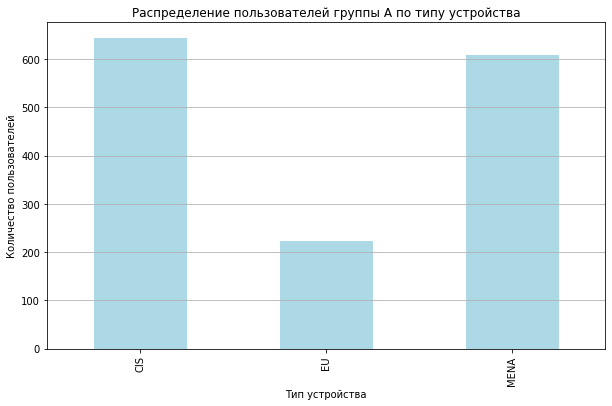

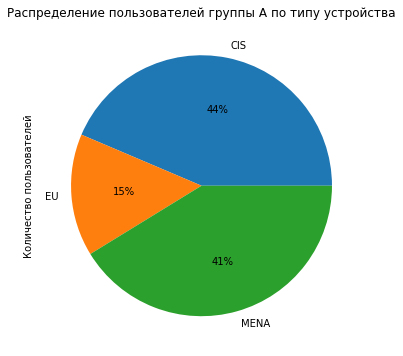

In [27]:
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().plot(kind ='bar',
                                                                                           color = 'lightblue',
                                                                                           figsize = (10,6),
                                                                                           xlabel = 'Тип устройства',
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы А по типу устройства')
plt.grid(axis = 'y')
plt.show()
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().plot(kind ='pie',
                                                                                           figsize = (10,6),
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы А по типу устройства',
                                                                                         autopct='%1.0f%%')
plt.show()

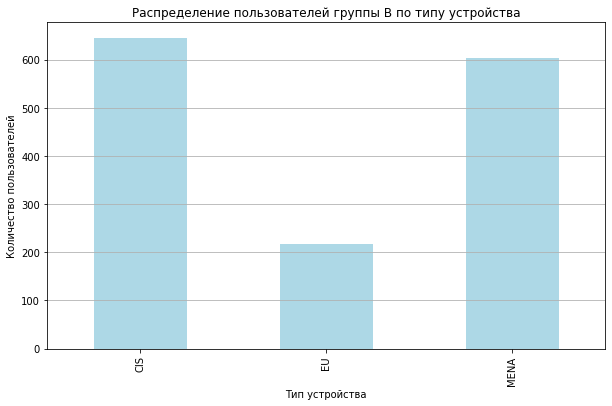

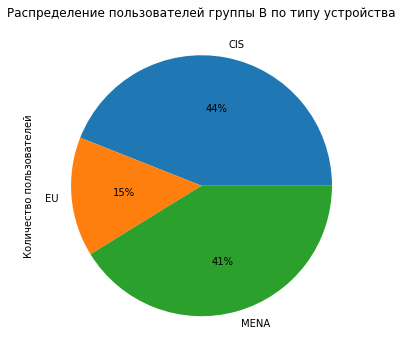

In [28]:
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().plot(kind ='bar',
                                                                                           color = 'lightblue',
                                                                                           figsize = (10,6),
                                                                                           xlabel = 'Тип устройства',
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы B по типу устройства')
plt.grid(axis = 'y')
plt.show()
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().plot(kind ='pie',
                                                                                           figsize = (10,6),
                                                                                           ylabel = 'Количество пользователей',
                                                                                           title = 'Распределение пользователей группы B по типу устройства',
                                                                                         autopct='%1.0f%%')
plt.show()

Данные распределились почти одинаково, но с небольшими различиями в процентном соотношении. Учитывая, что данные представлены за один день, а тестирование длиться 4 дня, то говорить о различиях между группами слишком рано, ведь отчилия минимальны.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

На основе полученных результатов можно сделать следующие выводы:
- присутсвует разница в сформированости групп (группа И больше чем группа А 50.19% и 49.81% соотвественно)
- выборки независимы, пересечений в пользователях в двух группах нет;
- при рассмотрении распределения пользователей по группам в зависимости от устройств и региона замечено, что в контрольной и тестовой группе есть различия, однако они не велики и на данном этапе ими можно принебречь.

Стоит наблюдать за распределением данных далее, чтобы успеть вовремя остановить тест.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [29]:
sessions_test = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_test.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [30]:
sessions_test['good_session'] = sessions_test.apply(good_sessions, axis = 1)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


In [31]:
sessions_test['user_id'].nunique()

30579

В тесте приняло участие 30579 пользователей.

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [32]:
sessions_test.groupby(['session_date', 'test_group'])['session_id'].count()

session_date  test_group
2025-10-14    A             1502
              B             1628
2025-10-15    A             2235
              B             2283
2025-10-16    A             3280
              B             3241
2025-10-17    A             4089
              B             4054
2025-10-18    A             5013
              B             5059
2025-10-19    A             6535
              B             6779
2025-10-20    A             5837
              B             6089
2025-10-21    A             3927
              B             3981
2025-10-22    A             3083
              B             3111
2025-10-23    A             2470
              B             2548
2025-10-24    A             2090
              B             2068
2025-10-25    A             1897
              B             1814
2025-10-26    A             1669
              B             1692
2025-10-27    A             1454
              B             1517
2025-10-28    A             1279
              B   

In [33]:
sessions_test.groupby('test_group')['session_id'].count()

test_group
A    49551
B    50454
Name: session_id, dtype: int64

In [34]:
100 * sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()/sessions_test['session_id'].nunique(), 100 * sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()/sessions_test['session_id'].nunique()

(49.54852257387131, 50.45147742612869)

Процентное соотношение демонстрирует почти одинаковое распределенеие по группам: 49.55% для группы А и 50.45 для группы В. Разницей можно принебречь.

In [35]:
group_a = sessions_test[sessions_test['test_group']=='A']['user_id']
group_b = sessions_test[sessions_test['test_group']=='B']['user_id']
intersection = list(set(group_a)&set(group_b))
display(intersection)

[]

Пересечений пользователей в выборках не обнаружено. Приступаем к проверке равенства двух выборок на основе статистического теста.

Выдвинем дополнительную гипотезу: Нулевая - Средние двух метрик равны (H0 : µA = µB), Альтернативная - Средние двух метрик не равны (H0 : µA != µB)



In [36]:
from scipy.stats import ttest_ind
a = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].nunique()
b = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].nunique()

alpha = 0.05
stat_ttest, p_value_ttest = ttest_ind(a,b, alternative = 'two-sided', equal_var=False)
if p_value_ttest > alpha:
   display(p_value_ttest)
   display('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
   display(p_value_ttest)
   display('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

0.9382195854082714

'Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны'

Полученное значение p_value демонстрирует что различия в полученных группах статистически не значимы.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [37]:
display(sessions_test[sessions_test['test_group']=='A']['good_session'].mean())
display(sessions_test[sessions_test['test_group']=='B']['good_session'].mean())
display(abs(sessions_test[sessions_test['test_group']=='A']['good_session'].mean() - sessions_test[sessions_test['test_group']=='B']['good_session'].mean()) * 100)

0.3077233557344958

0.31828992745867524

1.0566571724179463

Разница между долями успешных сессий составляет 1,06%. Однако, необходимо проверить насколько данный результат статистически значим.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Для оценки статистической значимости доли успешных сессий необходимо провести z-тест, однако для начала следует оценить предпосылку о достаточном размере выборки для его оценки.

In [38]:
n_a, n_b = sessions_test[sessions_test['test_group'] == 'A'].shape[0] , sessions_test[sessions_test['test_group'] == 'B'].shape[0]
m_a, m_b = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session'] == 1)].shape[0], sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session'] == 1)].shape[0]
p_a, p_b = m_a/n_a, m_b/n_b
display(f'n_a={n_a}, n_b={n_b}')
display(f'm_a={m_a}, m_b={m_b}')
display(f'p_a={p_a}, n_b={p_b}')
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

'n_a=49551, n_b=50454'

'm_a=15248, m_b=16059'

'p_a=0.3077233557344958, n_b=0.31828992745867524'

Предпосылка о достаточном количестве данных выполняется!


**Гипотеза:**

**Нулевая:** После внедрения рекомендаций доля успешных сессий не изменилась (H0 : µA = µB) 

**Альтернативная:** После внедрения рекомендаций доля успешных сессий изменилась (H1 : µA ≠ µB) 

**Основная метрика для проверки равенства выборок**: среднее количество страниц просмотренных пользователями в рамках сессии.

In [39]:
# Проведем z-тест
from statsmodels.stats.proportion import proportions_ztest
stat_ztest, p_value_ztest = proportions_ztest([m_a, m_b], [n_a,n_b], alternative = 'two-sided')
display(f'z-статистика = {stat_ztest}')
if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest}')
    print('Нулевая гипотеза не находит подтверждения!')

'z-статистика = -3.602684259949491'

pvalue=0.0003149479976072246
Нулевая гипотеза не находит подтверждения!


Значение pvalue оказалось меньше уровня значимости, что говорит о значимости расхождений и подветрждении первончальной гипотезы о влияние нового алгоритма на количество на долю успешных сессий.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

В ходе эксперимента было проведено А/В-тестирование, направленное на проверку нового алгоритма подбора более интересного контента для пользователей. В начале эксперимента была выдвинута гипотеза о том, что новый алгоритм полвияет на долю успешных сессий (сессии с просмотром 4 и более страниц).

В тестирование приняли участие 30579 пользователей системы, а само тестирование длилось 20 дней (тестирование для оценки результата можно было закончить раньше, по предварительным расчетом срок проведения теста для получения необходимой выборки составлял 4 дня).

Внедрение нового алгоритма повлияло на рост ключевой метрики, доля успешных сессий в группе В выше на 1,1%. Об этом свидетельствует и z-статистика, которая имеет отрицательное значение, что говорит доля упешных сессий в группе В больше.

Значение pvalue составило 0.0003149479976072246 что ниже вероятности ошибки первого рода. Таким образом альтернативную гипотезу можно смело подтвердить и значения метрики в группе В больше и статистически значимы.

Стоит расскатить фичу на всех пользователей приложения.